In [14]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

### SLS Dataset Review

In [16]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\AppData\Local\Temp\ipykernel_24304\701159028.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")


In [17]:
sls.iddesa.unique().shape

(5957,)

In [18]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [19]:
sls_new = sls.set_index("iddesa").join(idm.set_index("bps_kelurahan_kode"), how ="left", rsuffix = "idm")

In [20]:
sls_new["iddesa"] = sls_new.index
sls_new["bps_kelurahan_kode"] = sls_new.index

In [21]:
sls_new.shape

(222861, 97)

In [22]:
sls_new = sls_new.drop_duplicates(["idsls"])

In [23]:
sls_new.shape

(219919, 97)

#### Preprocessing

In [24]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls spot ES RES/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/10. Desa SPOT 10m ES RES'

In [25]:
os.chdir(destpath)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [26]:
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].empty):
            if(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [14:36, 876.53s/it]


In [27]:
test_path = 'C:/Users/jwst2/Python/tesis/jpg/IDM/test sls 10m es res spot/'

In [29]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/test_idm_res.csv")

In [30]:
split_test = split

In [31]:
os.chdir(test_path)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [32]:
catlist = ["MAJU MANDIRI","TERTINGGAL BERKEMBANG"]

In [33]:
destpath + catlist[0]

'C:/Users/jwst2/Python/tesis/jpg/IDM/10. Desa SPOT 10m ES RESMAJU MANDIRI'

In [34]:
for i in range(0,2):
    print(catlist[i])
    yourpath = destpath +"/"+ catlist[i]
    for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
        for name in files:
            try :
                if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                    shutil.move(os.path.join(root, name), test_path+catlist[i]+"/"+name)
            except Exception:
                print(name)
                pass 

MAJU MANDIRI


1it [00:39, 39.27s/it]


TERTINGGAL BERKEMBANG


1it [00:50, 50.93s/it]


### Run Dataset

In [35]:
path = Path.cwd() / (destpath)

In [36]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('MAJU MANDIRI'),Path('TERTINGGAL BERKEMBANG')]

In [37]:
fname = (path/"MAJU MANDIRI").ls()[0]
fname

Path('MAJU MANDIRI/32010200010001.jpg')

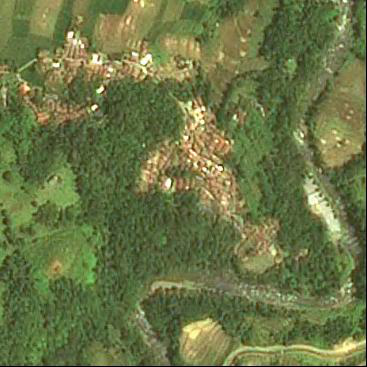

In [38]:
img = Image.open(fname)
img

In [39]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(64)) # data augmentation (mult multiplies the default transformation values)

In [40]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


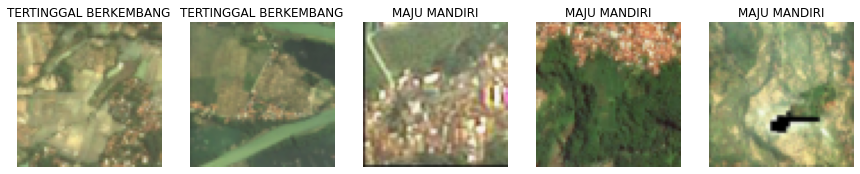

In [41]:
dls.show_batch(nrows=1, ncols=5)

In [42]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0003311311302240938)

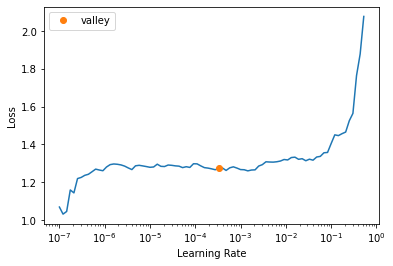

In [43]:
learn.lr_find()

In [44]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(7,lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.716575,0.988384,0.628020,0.598699,0.634847,0.598699,0.585062,0.657294,28:31
1,0.673916,0.650424,0.636050,0.622815,0.629664,0.622815,0.622973,0.672917,22:42
2,0.660453,1.340890,0.645136,0.636551,0.639184,0.636551,0.637206,0.684747,22:41
3,0.644581,2.460241,0.652321,0.643951,0.646620,0.643951,0.644657,0.695225,22:38
4,0.631162,0.630257,0.661196,0.647932,0.656733,0.647932,0.648589,0.709834,22:42
5,0.615374,0.640690,0.667958,0.648061,0.670201,0.648061,0.646485,0.718115,22:50
6,0.615382,0.610055,0.669578,0.653315,0.667943,0.653315,0.653436,0.722471,22:42


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (1235

In [46]:
dls.vocab

['MAJU MANDIRI', 'TERTINGGAL BERKEMBANG']

In [47]:
dls.train.items[1500]

Path('TERTINGGAL BERKEMBANG/32080600171005.jpg')

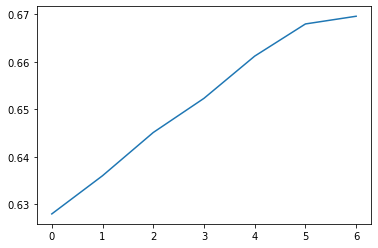

In [48]:
plt.plot(L(learn.recorder.values).itemgot(2));

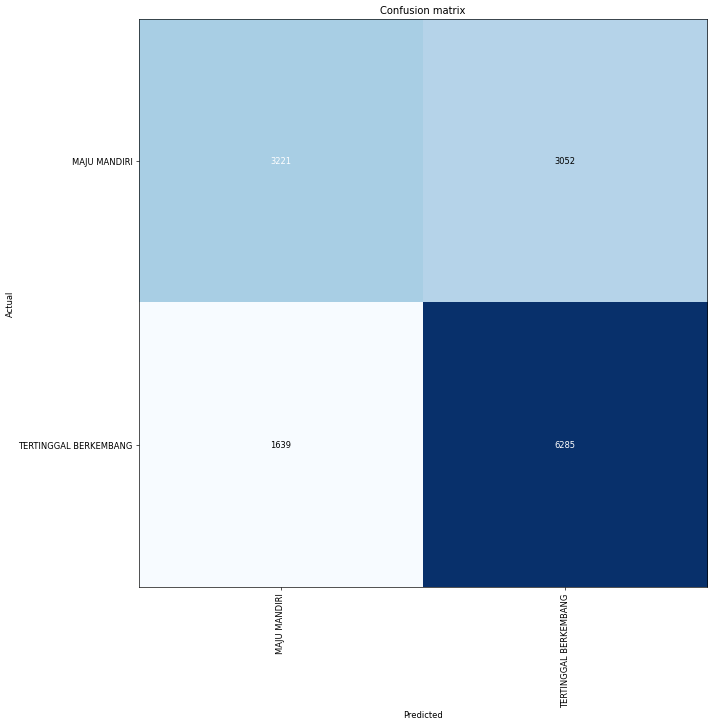

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(3, figsize=(20,11))

In [50]:
learn.export('C:/Users/jwst2/Python/tesis/models/SLS Densenet SPOT ES RES.pkl')

### Up level

In [51]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if('TERTINGGAL BERKEMBANG' in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [52]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (123587689 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [42]:
pd.value_counts(true_label)

1    80131
0    60753
dtype: int64

In [54]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.323894,0.676106,32120410060005,1.0,3212041006
1,0.887978,0.112022,32041800070043,0.0,3204180007
2,0.285713,0.714287,32140500140013,1.0,3214050014
3,0.563298,0.436702,32050700050008,0.0,3205070005
4,0.503841,0.496159,32041910070018,0.0,3204191007


In [55]:
pd.value_counts(df.stat)

1.0    83075
0.0    44699
Name: stat, dtype: int64

In [56]:
df["true_lab"] = true_label

In [57]:
pd.value_counts(df.true_lab)

1    71539
0    56235
Name: true_lab, dtype: int64

In [58]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.6714355033105327

In [59]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.323894,0.676106,32120410060005,1.0,3212041006,0
1,0.887978,0.112022,32041800070043,0.0,3204180007,0
2,0.285713,0.714287,32140500140013,1.0,3214050014,1
3,0.563298,0.436702,32050700050008,0.0,3205070005,0
4,0.503841,0.496159,32041910070018,0.0,3204191007,1


In [60]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [61]:
desa_pred.columns = ["pred","true"]

In [62]:
pd.value_counts(df.stat)

1.0    83075
0.0    44699
Name: stat, dtype: int64

In [65]:
for i in np.arange(0.0, 0.95, 0.025):
    value = round(i,3)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred >value,"label"+str(value)] = 1

In [66]:
desa_pred.head()

,pred,true,label0.0,label0.05,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,...,label0.475,label0.525,label0.575,label0.625,label0.675,label0.725,label0.775,label0.825,label0.875,label0.925
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.927273,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010003,0.950000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010004,0.888889,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3201010005,0.960000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [67]:
for j in range(2,40):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.0
accuracy : 0.6432207311429894
precision : 0.6411157993436475
result label0.05
accuracy : 0.6554835724201759
precision : 0.6500358080687515
result label0.1
accuracy : 0.6675150393336419
precision : 0.6595174262734584
result label0.15
accuracy : 0.6770013882461823
precision : 0.6676602086438153
result label0.2
accuracy : 0.6888014807959278
precision : 0.6780177890724269
result label0.25
accuracy : 0.6943544655252198
precision : 0.6855952070851784
result label0.3
accuracy : 0.6968995835261453
precision : 0.6912626531699521
result label0.35
accuracy : 0.7012956964368348
precision : 0.6974219810040706
result label0.4
accuracy : 0.7031466913465988
precision : 0.7047299188357122
result label0.45
accuracy : 0.7043035631652013
precision : 0.7118937644341802
result label0.5
accuracy : 0.7096251735307728
precision : 0.7248868778280543
result label0.55
accuracy : 0.7107820453493753
precision : 0.7321539416511483
result label0.6
accuracy : 0.7105506709856548
precision : 0.7416747494

In [68]:
pd.value_counts(desa_pred.true)

1.0    2746
0.0    1576
Name: true, dtype: int64

### Test result

In [69]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [70]:
len(test_files)

16516

In [71]:
test_dl = learn.dls.test_dl(test_files)

In [72]:
preds,_ = learn.get_preds(dl  =test_dl)

In [73]:
str(test_files[1])[-18:-4]

'32010200180002'

In [74]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [75]:
test = pd.DataFrame(preds)

In [76]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [77]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [78]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.735977,0.264023,32010200180001,0,3201020018,0.0
1,0.776474,0.223526,32010200180002,0,3201020018,0.0
2,0.724833,0.275167,32010200180003,0,3201020018,0.0
3,0.785932,0.214068,32010200180004,0,3201020018,0.0
4,0.674112,0.325888,32010200180005,0,3201020018,0.0


In [85]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [86]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010008,0.896552,1.0
3201020018,0.363636,0.0
3201030001,1.000000,1.0
3201030002,0.760870,0.0
3201040001,1.000000,0.0
...,...,...
3217150012,1.000000,0.0
3218040012,1.000000,1.0


In [87]:
desa_pred_test.columns = ["pred","true"]

In [124]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.4,"pred_lab"] = 1

In [125]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010008,0.896552,1.0,1
3201020018,0.363636,0.0,0
3201030001,1.000000,1.0,1
3201030002,0.760870,0.0,1
3201040001,1.000000,0.0,1
...,...,...,...
3217150012,1.000000,0.0,1
3218040012,1.000000,1.0,1
3218100005,0.840000,1.0,1


In [126]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.7291666666666666
balanced_accuracy_score : 0.6586657651566373
precision : 0.7291666666666666
recall : 0.9150326797385621
f1 : 0.8115942028985508
rocauc : 0.6586657651566373
